## ABOUT THESE SET OF NOTEBOOKS:

PART : 2 Finetuning FUNSD on LiLT


#### CREDITS : [Neil Rogge's Github Repo](https://github.com/NielsRogge/Transformers-Tutorials)

In [1]:
## Requirements

!pip install -qqq git+https://github.com/huggingface/transformers.git
!pip install -qqq pytorch_lightning
!pip install -qqq datasets
!pip install -qqq wandb
!pip install -qqq evaluate seqeval

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.1 requires transformers<4.21,>=4.1, but you have transformers 4.26.0.dev0 which is incompatible.


In [2]:
## Logging into wandb

import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api")
wandb.login(key=secret_value_0)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Step : 1 Downloading and exploring the dataset a bit

In [3]:
## Requirements
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Downloading the dataset
import datasets
from datasets import load_dataset

import evaluate
import torch.nn.functional as F

## pytorch lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

from torch.optim import AdamW
from torch.utils.data import DataLoader

In [4]:
dataset = load_dataset("nielsr/funsd")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset funsd downloaded and prepared to /root/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/8b0472b536a2dcb975d59a4fb9d6fea4e6a1abe260b7fed6f75301e168cbe595. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
## Taken from here : https://huggingface.co/spaces/jinhybr/OCR-LayoutLM-v3-Document-Parser/blob/main/app.py

labels = dataset["train"].features["ner_tags"].feature.names
id2label = {v: k for v, k in enumerate(labels)}

In [6]:
## Exploring the dataset

sample = dataset["train"][6]
sample

{'id': '6',
 'words': ['FAX:',
  'DATE:',
  'FROM:',
  'CHARGEBACK:',
  'RECIPIENT',
  'COMPANY',
  'FAX',
  'No.',
  'COMMENTS',
  'No:',
  'Name:',
  'Yes',
  'Confirmation:',
  '2074956978',
  'WINSTON',
  '&',
  'STRAWN',
  'Fax',
  'Cover',
  'Sheet',
  'MAMI',
  'TRIAL',
  'SITE,',
  '2000',
  'FIRST',
  'UNION',
  'FINANCIAL',
  'CENTER,',
  '200',
  'SOUTH',
  'BISCAYNE',
  'BOULEVARD',
  'MIAMI,',
  'FLORIDA',
  '33131',
  '(305)',
  '400',
  '6',
  '06',
  '200',
  'PARK',
  'AVENUE',
  'NEWYORK',
  'NY',
  '10166',
  '4193',
  '212',
  '294-6700',
  '400',
  'L.',
  'STREET',
  'N',
  'WASHWINGTON',
  'DC',
  '20005',
  '3502',
  '202',
  '371',
  '5700',
  '35',
  'WEST',
  'WACKER',
  'CHICAGO.',
  'IL',
  '30601',
  '312-',
  '588',
  '5800',
  '21',
  'AVENUE',
  'VICTOR',
  'HUGO',
  '75',
  'PARIS,',
  'FRANCE',
  '33-',
  '53',
  '64',
  '62',
  '82',
  'Fax',
  'Number:',
  '305',
  '400-',
  '6107',
  'Kevin',
  'Narko',
  '10/',
  '13/',
  '99',
  '4162/',
  '158',

## Step : 2 Preparing the dataset for modeling


Let's understand how are we going to deal with it.

* The entire notebook is depended on measuring the performance of LayoutLMV3 on FUNSD, hence we can consider this as a task of token classification
* Hence, we would initially load the LayoutLMV3 (not AutoModelForTokenClassification, but just AutoModel, just to see the inner working)
* And then, what are input values require to it, and then prepare the data accordingly
* And finally, we would integrate it with PyTorch Lightning for ease of training and testing, that's it


In [7]:
from transformers import AutoModel
import torch.nn as nn

class LayoutLMV3ForTokenClassification(nn.Module):
    
    def __init__(self, num_classes : int = 7):    ## 7 -> 0 to 6 classes
        super().__init__()
        
        self.model = AutoModel.from_pretrained("nielsr/lilt-roberta-en-base")
        hidden_dim = self.model.config.hidden_size    ## 768
        self.cls_layer = nn.Sequential(nn.Linear(in_features = hidden_dim,
                                                out_features = hidden_dim),
                                      nn.ReLU(), nn.Linear(in_features = hidden_dim, out_features = num_classes))
        
    def forward(self, batch):
        output = self.model(input_ids=batch["input_ids"],
                                bbox=batch["bbox"],
                                attention_mask=batch["attention_mask"],
                                ).last_hidden_state[:, :512, :]   ## The output is [none, 512, 768], 
                                                                                                
        
        output = self.cls_layer(output)
        
        return {"logits" : output}

In [8]:
# ## Printing what the model requires

# model = LayoutLMV3ForTokenClassification()
# model.model.forward?

In [9]:
## https://github.com/huggingface/transformers/tree/main/examples/research_projects/layoutlmv3

from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

column_names = dataset["train"].column_names

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

In [10]:
from transformers import LayoutLMv3Processor
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base",apply_ocr=False)
tokenizer = processor.tokenizer

## This function would map each of the sample to the appropriate format as required by the model
def prepare_dataset(sample):
    
    ## sample can be a single dict, or a list of dict, depending upon if we don't use batch or use batch
    if isinstance(sample, dict):
        tokens = sample["words"]
        bbox = sample["bboxes"]
        ner_tags = sample["ner_tags"]
        
        encoding = tokenizer( text = tokens, boxes = bbox, word_labels = ner_tags, truncation=True, padding="max_length")
    
    elif isinstance(sample, datasets.arrow_dataset.Batch):
        tokens = sample["words"]
        bbox = sample["bboxes"]
        ner_tags = sample["ner_tags"]
        
        encoding = tokenizer(text = tokens, boxes = bbox, word_labels = ner_tags, truncation=True, padding="max_length")
        
    else:
        tokens = [item["words"] for item in sample]
        bbox = [item["bboxes"] for item in sample]
        ner_tags = [item["ner_tags"] for item in sample]
        
        encoding = tokenizer(text = tokens, boxes = bbox, word_labels = ner_tags, truncation=True, padding="max_length")
        
    return encoding

Downloading:   0%|          | 0.00/275 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [11]:
train_dataset = dataset["train"].map(
    prepare_dataset,
    batched=True,
    remove_columns=column_names,
    features=features,
)

eval_dataset = dataset["test"].map(
    prepare_dataset,
    batched=True,
    remove_columns=column_names,
    features=features,
)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [12]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask','bbox', 'labels'])
eval_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask','bbox', 'labels'])

## Step : 3 Integrating with wandb and Lightning


This step involves defining a datamodule and lightning object for training the model and logging it to wandb

In [13]:
class DataModule(pl.LightningDataModule):

  def __init__(self, batch_size:int = 4):
    super(DataModule, self).__init__()
    self.batch_size = batch_size

  def train_dataloader(self):
    return DataLoader(train_dataset, batch_size = self.batch_size,
                      shuffle = True)
    
  def val_dataloader(self):
    return DataLoader(eval_dataset, batch_size = self.batch_size,
                      shuffle = False)

In [14]:
import torch

## Sanity checks
# dl = DataModule()
# device = "cuda" if torch.cuda.is_available() else "cpu"
# sample = next(iter(dl.train_dataloader()))

# for key in list(sample.keys()):
#     sample[key] = sample[key].to(device)

# model = LayoutLMV3ForTokenClassification().to(device)
# output = model(sample)
# output['logits'].shape

In [15]:
## https://github.com/NielsRogge/Transformers-Tutorials/blob/master/LayoutLMv3/Fine_tune_LayoutLMv3_on_FUNSD_(HuggingFace_Trainer).ipynb

## Would be useful for prediction
def get_labels(predictions, references):

    # Transform predictions and references tensors to numpy arrays
    if predictions.device.type == "cpu":
        y_pred = predictions.detach().clone().numpy()
        y_true = references.detach().clone().numpy()

    else:
        y_pred = predictions.detach().cpu().clone().numpy()
        y_true = references.detach().cpu().clone().numpy()

    # Remove ignored index (special tokens)
    true_predictions = [
        [labels[p] for (p, l) in zip(pred, gold_label) if l != -100]
        for pred, gold_label in zip(y_pred, y_true)
    ]
    true_labels = [
        [labels[l] for (p, l) in zip(pred, gold_label) if l != -100]
        for pred, gold_label in zip(y_pred, y_true)
    ]
    return true_predictions, true_labels

In [16]:
class PLModel(pl.LightningModule):

  def __init__(self, lr = 5e-5):

    super(PLModel, self).__init__()
    self.save_hyperparameters()
    
    self.model = LayoutLMV3ForTokenClassification()

    ## Metrics
    self.train_metric = evaluate.load("seqeval")
    self.val_metric = evaluate.load("seqeval")

    ## Parameters
    self.lr = lr
  
  def forward(self, batch):
    return self.model(batch)

  def configure_optimizers(self):
    return AdamW(self.model.parameters(), lr = self.lr)

  def training_step(self, batch, batch_idx):

    ## Forward Propagatipn
    outputs = self.forward(batch)

    ## Predictions and adding the metrics
    predictions = outputs['logits'].argmax(-1)
    true_predictions, true_labels = get_labels(predictions, batch["labels"])
    self.train_metric.add_batch(references=true_labels, predictions=true_predictions)

    ## Logging Purpose
    results = self.train_metric.compute()
    loss = F.cross_entropy(outputs['logits'].view(-1, 7), batch["labels"].view(-1))
    
    self.log("train_loss", loss.item(), prog_bar = True)
    self.log("train_overall_fl", results["overall_f1"], prog_bar = True)
    self.log("train_overall_recall", results["overall_recall"], prog_bar = True)
    self.log("train_overall_precision", results["overall_precision"], prog_bar = True)

    return loss

  def validation_step(self, batch, batch_idx):

    outputs = self.forward(batch)
    predictions = outputs['logits'].argmax(-1)
    true_predictions, true_labels = get_labels(predictions, batch["labels"])
    self.val_metric.add_batch(references=true_labels, predictions=true_predictions)

    ## Logging Purpose
    results = self.val_metric.compute()
    loss = F.cross_entropy(outputs['logits'].view(-1, 7), batch["labels"].view(-1))
    
    self.log("val_loss", loss.item(), prog_bar = True)
    self.log("val_overall_fl", results["overall_f1"], prog_bar = True)
    self.log("val_overall_recall", results["overall_recall"], prog_bar = True)
    self.log("val_overall_precision", results["overall_precision"], prog_bar = True)
    
    return loss

In [17]:
def main():
    
    checkpoint_callback = ModelCheckpoint(
        dirpath="./lilt/models", monitor="val_loss", mode="min", filename = 'lilt_best_ckpt'
    )
    
    wandb.init(project="Document AI FUNSD")
    wandb_logger = WandbLogger(project="Document AI FUNSD", entity="iakarshu")
    
    max_epochs = 50
    trainer = pl.Trainer(
        max_epochs = max_epochs,
        default_root_dir="./lilt/logs",
        accelerator="auto", 
        devices="auto",
        logger=wandb_logger,
        callbacks=[checkpoint_callback]
    )
    
    pl_model = PLModel()
    pl_dl = DataModule()
    
    trainer.fit(pl_model, pl_dl)

    return pl_model, pl_dl

In [18]:
if __name__ == "__main__":
  pl_model, pl_dl = main()

wandb: Currently logged in as: iakarshu. Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/loggers/wandb.py:353: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"


Downloading:   0%|          | 0.00/697 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1896: PossibleUserWarning: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Step : 4 Evaluation

In [19]:
import os
model_path = os.path.join('./lilt/models', os.listdir('./lilt/models')[0])
pl_model = pl_model.load_from_checkpoint(model_path)

In [20]:
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
eval_metric = evaluate.load("seqeval")
pl_model.eval();

model = pl_model.model.to(device)

for idx, batch in enumerate(tqdm(pl_dl.val_dataloader())):
    # move batch to device
    batch = {k:v.to(device) for k,v in batch.items()}
    with torch.no_grad():
      outputs = model(batch)

    predictions = outputs['logits'].argmax(-1)
    true_predictions, true_labels = get_labels(predictions, batch["labels"])
    eval_metric.add_batch(references=true_labels, predictions=true_predictions)

  0%|          | 0/13 [00:00<?, ?it/s]

In [21]:
results = eval_metric.compute()

In [22]:
for key in ['overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy']:
  print_statement = '{0: <30}'.format(str(key) + " has value:")
  print(print_statement, results[key])

overall_precision has value:   0.6918001885014138
overall_recall has value:      0.7292598112270243
overall_f1 has value:          0.7100362756952842
overall_accuracy has value:    0.7670272197789136


## Step : 5 Visualizing the Prediction on test dataset

In [23]:
sample = eval_dataset[0]
for key in list(sample.keys()):
    sample[key] = sample[key].unsqueeze(0).to(device)

In [24]:
with torch.no_grad():
    outputs = model(sample)
predictions = outputs['logits'].argmax(-1)

In [25]:
pad_token_id = 0
for i, j in enumerate(sample["input_ids"][0]):
    if j == 1:
        pad_token_id = i
        break
        
predictions = predictions.squeeze(0)[:pad_token_id]
actual_prediction = [i.item() for i in predictions]

for key in list(sample.keys()):
    sample[key] = sample[key].squeeze(0)

In [26]:
sample['ner_tags'] = actual_prediction

In [27]:
from PIL import Image

sample['image'] = Image.open(dataset['test'][0]['image_path']).convert("RGB").resize((1000, 1000))

In [28]:
sample.pop("attention_mask")
sample['bboxes'] = sample.pop("bbox").tolist()

In [29]:
## Visualizing the bounding boxes

def plot_visualization(sample : dict):

    from PIL import ImageDraw, ImageFont

    img = sample["image"]
    bbox = sample["bboxes"]
    ner_tags = sample["ner_tags"]
    
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()
    
    for box, predicted_label in zip(bbox, ner_tags):

        ## The bounding box has been rescaled to the range of [0, 1000] considering an image is [1000, 1000]
        box[0] = int(img.size[0] * box[0] / 1000)
        box[1] = int(img.size[1] * box[1] / 1000)
        box[2] = int(img.size[0] * box[2] / 1000)
        box[3] = int(img.size[1] * box[3] / 1000)
        
        draw.rectangle(box, outline = "violet")
        draw.text(
            (box[0] + 10, box[1] - 10),
            text=labels[predicted_label],
            fill="green",
            font=font,
        )
        
    return img

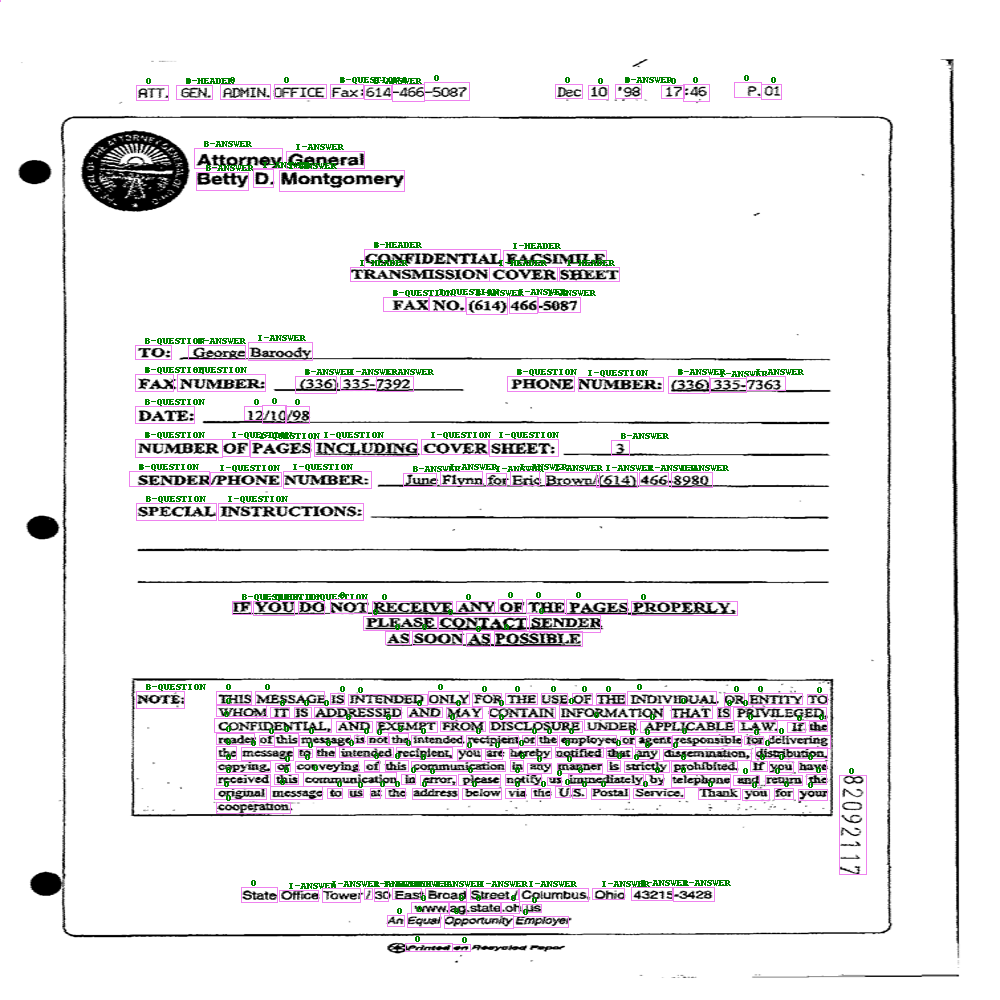

In [30]:
plot_visualization(sample)